# Your First Features

## Reading your First Volume
The HTRC Feature Reader library has three main objects: **FeatureReader**, **Volume**, and **Page**.

The **FeatureReader** object is the interface for loading the dataset files and making sense of them. The files are originally in the JSON format and compressed, which FeatureReader decompresses and parses. It creates an iterator over files, allowing one-by-one access to the files as Volumes. A **Volume** is a representation of a single book or other work. This is where you access features about a work. Many features for a volume are collected from individual pages, to access Page information, you can use the **Page** object.

Let's load two volumes to understand how the FeatureReader works.

In [ ]:
from htrc_features import FeatureReader
# Remember to use '/' for windows, else '\'
paths = ['data/sample-file1.basic.json.bz2', 'data/sample-file2.basic.json.bz2']
fr = FeatureReader(paths)
for vol in fr.volumes():
    print(vol.title)

June / by Edith Barnard Delano ; with illustrations.
You never know your luck; being the story of a matrimonial deserter, by Gilbert Parker ... illustrated by W.L. Jacobs.


Here, the FeatureReader is imported and initialized with file paths pointing to two Extracted Features files. We wrote out the file paths directly here, though for advanced use there are better ways to [deal with paths](https://docs.python.org/2/library/os.path.html#os.path.join) in Python. An initialized FeatureReader can be iterated through with a `for` loop. The code in the loop is run for every single volume: the Volume() object for the first volume is assigned to the variable `vol`, the loop code is run, then the next volume is set to `vol`, and so on.

You may recognize `for` loops from past experience iterating through what is known as a `list` in Python. However, it is important to note that `fr.volumes()` is *not* a list. If you try to access it directly, it won't print all the volumes; rather, it identifies itself as a different data structure known as a generator:

<img src="images/generator.png" width="500px">

What is a generator, and why do we iterate over it?

Generators are the key to working with lots of data. They allow you to iterate over a set of items that don't exist yet, preparing them only when it is their turn to be acted upon. 

Remember that there are 4.8 million volumes in the Extracted Features dataset. When coding at that scale, you need to be be mindful of two rules:

1. Don't hold everything in memory: you can't. Use it, reduce it, and move on.
2. Don't devote cycles to processing something before you need it.

A generator simplifies such on-demand, short term usage. Think of it like a pizza shop making pizzas when a customer orders, versus one that prepares them beforehand. The traditional approach to iterating through data is akin to making *all* the pizzas for the day before opening. Doing so would make the buying process quicker, but also adds a huge upfront time cost, needs larger ovens, and necessitates the space to hold all the pizzas at once. An alternate approach is to make pizzas on-demand when customers buy them, allowing the pizza place to work with smaller capacities and without having pizzas laying around the shop. This is the type of approach that a generator allows.

Volumes need to be prepared before you do anything with them, being read, decompressed and parsed. This 'initialization' of a volume is done when you ask for the volume, *not* when you create the FeatureReader. In the above code, after you run `fr = FeatureReader(paths)`, there are are still no `Volume` objects held behind the scenes: just the pointers to the file locations. The files are only read when their time comes in the loop on the generator `fr.volumes()`.

If you tried to read hundreds of volumes when the FeatureReader is initialized (as you can try, against our advice, with `list(fr.volumes())`, that command would take a very long time, and if you had a bug in later actions, the waiting would be for naught. With enough volumes, it is also likely that your system would run out of RAM, because all the volumes would be held in memory at the same time. Using the generator, Python assumes that you only need the volume within its turn in the loop: after moving on to the next volume in the iterator, the earlier one is thrown away. Because of this one-by-one reading, the items of a generator cannot be accessed out of order (e.g. you cannot ask for the third item of `fr.volumes()` without going through the first two first.

## What's in a volume?

Let's take a closer look at what features are accessible for volumes. For clarity, we'll grab the first volume to focus on, which can conveniently be accessed with the `first()` method. Any code you write can easily be run later with a `for vol in fr.volumes()` loop.

In [ ]:
# Reading a single volume
vol = fr.first()
vol

While the majority of the HTRC Extracted Features dataset is *features*, quantitative abstractions of a book's written content, there is also a small amount of metadata included for each volume. We already saw `Volume.title` accessed earlier. Other metadata includes:

- `Volume.id`: A unique identifier for the volume in the HathiTrust and the HathiTrust Research Center.
- `Volume.year`: The publishing date of the volume.
- `Volume.language`: The classified language of the volume.
- `Volume.oclc`: The OCLC control number(s).

The volume id can be used to pull more information from other sources. The scanned copy of the book can be found from the HathiTrust Digital Library, when available, by accessing `http://hdl.handle.net/2027/VOLUME_ID`. For this volume, that would be: http://hdl.handle.net/2027/nyp.33433074811310.

In [ ]:
print("http://hdl.handle.net/2027/%s" % vol.id)

http://hdl.handle.net/2027/nyp.33433074811310


[Digital copy of sample book](images/June-cover.png)

Since the focus of EF is features, more in-depth metadata like genre and subject class needs to be grabbed from other sources. For example, the HathiTrust Bibliographic API ([https://www.hathitrust.org/bib_api](https://www.hathitrust.org/bib_api)) returns information about a book specified by its id; for our current example, that is http://catalog.hathitrust.org/api/volumes/full/htid/nyp.33433074811310.json. Another additional data source for metadata is the HTRC Solr Proxy ([https://goo.gl/0f4nqi](https://wiki.htrc.illinois.edu/display/COM/Solr+Proxy+API+User+Guide)), which allows searches for many books at a time.

Data from the Solr Proxy is accessible for Public Domain volumes with `Volume.metadata`:

In [ ]:
extra_meta = vol.metadata
# Example field: call number
extra_meta['callnosort']

['PZ3.D3726 J']

Calling detailed metadata is useful for small data settings, but using it pings the HTRC servers and adds overhead, so an efficient large-scale algorithm should avoid `vol.metadata`.

## Our First Feature Access: Visualizing Words Per Page

It's time to access the first features of `vol`: a table of total words for every single page. These can be accessed simply by calling `vol.tokens_per_page()`.

> If you are using a Jupyter notebook, returning this table at the end of a cell formats it nicely in the browser. Below, you'll see us append `.head()` to the `tokens` table, which allows us to inspect just the first 5 rows. Jupyter automatically guessed that you want to display the information from the last code line of the cell.

In [ ]:
tokens = vol.tokens_per_page()
# Show just the first few rows, so we can look at what it looks like
tokens.head()

count
page       
1         5
2         0
3         1
4         0
5         1

This is a straightforward table of information, similar to what you would see in Excel or Google Spreadsheets. Listed in the table are page numbers and the count of words on each page. With only two dimensions, it is trivial to plot the number of words per page. The table structure holding the data has a `plot` method for data graphics. Without extra arguments, `tokens.plot()` will assume that you want a line chart with the page on the x-axis and word count on the y-axis.

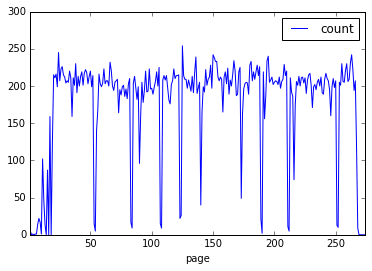

In [ ]:
%matplotlib inline
tokens.plot()

> `%matplotlib inline` tells Jupyter to show the plotted image directly in the notebook web page. It only needs to be called once, and isn't needed if you're not using notebooks.

On some systems, this may take some time the first time. It is clear that pages at the start of a book have less words per page, after which the count is fairly steady except for occasional valleys.

You may have some guesses for what these patterns mean; a look at the  scans ([http://hdl.handle.net/2027/nyp.33433074811310](http://hdl.handle.net/2027/nyp.33433074811310)) confirms that the large valleys are often illustration pages or blank pages, small valleys are chapter headings, and the upward pattern at the start is from front matter. 

Not all books will have the same patterns so we can't just codify these correlations for millions of books. However, looking at this plot makes clear an inportant assumption in text and data mining: that there are patterns underlying even the basic statistics derived from a text. The trick is to identify the real patterns and teach them to a computer.

### Understanding DataFrames

Wait... how did we get here so fast!? We went from a volume to a data visualization in two lines of code. The magic is in the data structure used to hold our table of data: a DataFrame.

In the first line, `vol.tokens_per_page()` returns a DataFrame, something that can be confirmed with `type(tokens)`. This means that _after setting `tokens`, we're no longer working with HTRC-specific code, just book data held in a common and very robust table-like construct from Pandas_. `tokens.head()` used a DataFrame method to look at the first few rows of the dataset, and `tokens.plot()` uses a method from Pandas to visualize data.

In [ ]:
type(vol.tokens_per_page())

pandas.core.frame.DataFrame

Many of the methods in the HTRC Feature Reader return DataFrames. The aim is to fit into the workflow of an experienced user, rather than requiring them to learn proprietary new formats. For new Python data mining users, learning to use the HTRC Feature Reader means learning many data mining skills that will translate to other uses.